# PyTorch & MNIST Intro

Let's go through a simple example of Pytorch and MNIST as a way to level set NNs and the use of notebooks. This is our first introductory class, with the initial goal of level setting and kicking-off discussions on training neural networks.

Please complete all challenges below for 10 (+ 2 extra) points in total. 

In [2]:
import torch
import torchvision
import matplotlib.pyplot as pl
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

## Dataset

MNIST is probably the most traditionally used dataset for neural networks, as it is a relatively challenging problem in computer vision: recognizing single-digit numbers from a hand-written digital format. Classically, this dataset takes the form of samples of $28 \times 28$ matrices.

In [39]:
batch_size_train = 64
batch_size_test = 1000

In [4]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_train,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(
                                        (0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_test,
    shuffle=True)

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

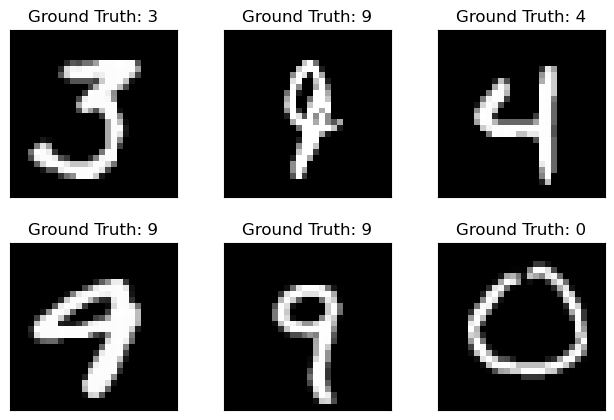

In [6]:
fig = pl.figure()
for i in range(6):
    pl.subplot(2,3,i+1)
    pl.tight_layout()
    pl.imshow(example_data[i][0], cmap='gray', interpolation='none')
    pl.title("Ground Truth: {}".format(example_targets[i]))
    pl.xticks([])
    pl.yticks([])
pl.show()

## Building the model

We need to specify the model through a Python class. Below we show how to create a Feedforward Neural Network model using Pytorch.

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self):
        input_dim = 28*28
        num_classes = 10
        super(FeedforwardNeuralNetModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, num_classes) 

    def forward(self, x):
        out = self.fc1(x)
        return F.log_softmax(out)

You'll need to instantiate this class as well as an optimizer, which will apply an algorithm to find the internal parameters of that model, such as matrix weights and biases. As an example, we will use the Stochastic Gradient Descent algorithm.

In [9]:
learning_rate = 0.001
momentum = 0.1
log_interval = 10

In [10]:
network = FeedforwardNeuralNetModel()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

## Training

Next, we will define the training procedure.

In [12]:
n_epochs = 5

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [13]:
! mkdir -p results

In [14]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # clears gradients
        output = network(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset))
            torch.save(network.state_dict(), f'./results/model_iteration-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'./results/optimizer_iteration-{epoch}.pth')

In [15]:
train(1)

/tmp/ipykernel_2928/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.462653
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.314634
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.172709
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.038150
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.011766
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.793893
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.784095
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.759681
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.595977
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.612938
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.453784
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.386518
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.438524
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.395226
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.237687
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.228426
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.189160
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.303519
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.156207
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.144378
Train Epoch: 1 [12800/60000 (

<br />
Alongside trainig, we will also monitor the performance of the model on a set of samples not seen during the training.

In [16]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

In [17]:
test()

/tmp/ipykernel_2928/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5596, Accuracy: 8696/10000 (87%)



## Training and evaluating for multiple epochs

Let's train now for all desired epochs.

In [18]:
for epoch in range(2, n_epochs + 1): # starts from the second iteration
  train(epoch)
  test()

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.666574
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.541078


/tmp/ipykernel_2928/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.564097
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.666229
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.488055
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.434858
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.543594
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.447622
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.549790
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.652385
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.670172
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.586397
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.554513
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.585009
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.654413
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.667827
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.639856
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.650934
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.545639
Train Epoch: 2 [12160/60000 (20%)]	Loss: 0.532475
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.734861
Train Epoch: 2 [13440/60000 (22%)]	Loss: 0.680402
Train Epoch: 2 [14080

# Model performance

Finally, we can inspect the results.

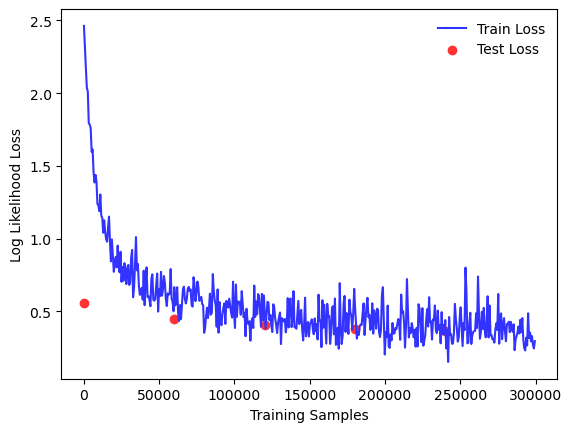

In [21]:
fig = pl.figure()
pl.plot(train_counter, train_losses, color=(0.2, 0.2, 1.0))
pl.scatter(test_counter[:-1], test_losses, color=(1.0, 0.2, 0.2))

pl.legend(['Train Loss', 'Test Loss'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')

pl.show()

It's always important to inspect anecdotes to convince yourself the model is behind as expected.

In [22]:
with torch.no_grad():
  output = network(example_data.reshape(1000, 28*28))

/tmp/ipykernel_2928/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


**Challenge: (2pt)** Can you explain why we are using `torch.no_grad()`?

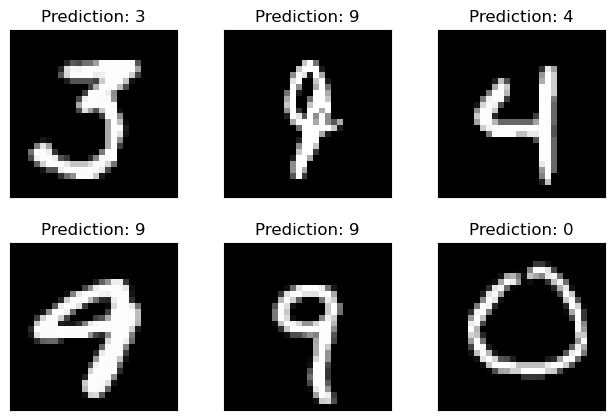

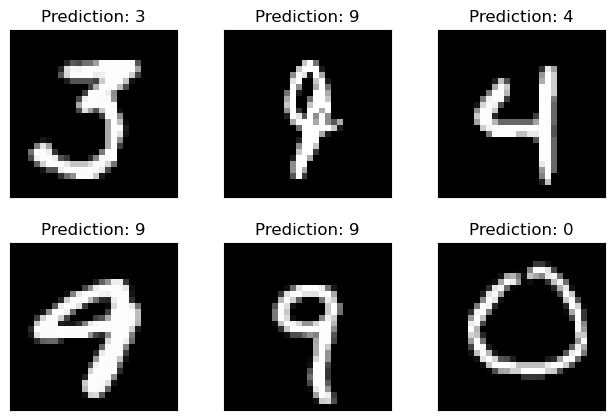

In [25]:
fig = pl.figure()
for i in range(6):
    pl.subplot(2,3,i+1)
    pl.tight_layout()
    pl.imshow(example_data[i][0], cmap='gray', interpolation='none')
    pl.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
    pl.xticks([])
    pl.yticks([])
fig

**Challenge: (1pt)** Re-do the plot above, but showcasing only miss-classifications (i.e. cases in which the model did wrong).

## Loading trained models

Eventually, you will want to load the model you trained in the past for either running inference or continue the training procedure. The functions we developed above save artifacts contain all of the metadata and data about the model, assuming you have the right model class. Let's inspect those files: 

In [26]:
! ls results

model_iteration-1.pth  model_iteration-5.pth	  optimizer_iteration-4.pth
model_iteration-2.pth  optimizer_iteration-1.pth  optimizer_iteration-5.pth
model_iteration-3.pth  optimizer_iteration-2.pth
model_iteration-4.pth  optimizer_iteration-3.pth


To load a model:

In [27]:
trained_model = FeedforwardNeuralNetModel()
model_state_dict = torch.load("results/model_iteration-1.pth")
trained_model.load_state_dict(model_state_dict)

<All keys matched successfully>

Before proceeding, let's inspect `model_state_dict`

In [28]:
model_state_dict.keys()

odict_keys(['fc1.weight', 'fc1.bias'])

In [29]:
model_state_dict['fc1.weight'].shape

torch.Size([10, 784])

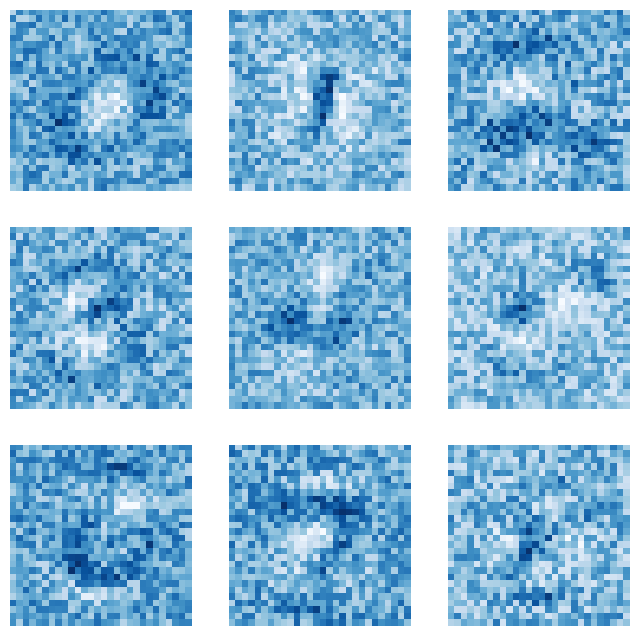

In [36]:
f,axs = pl.subplots(3,3, figsize=(8,8))

c = 0
for ax in axs:
    for sax in ax:
        sax.imshow(model_state_dict['fc1.weight'][c].reshape((28,28)), 
                   cmap = pl.get_cmap('Blues'))
        c += 1
        sax.axis('off')

pl.show()

Let's do the same for the optimizer

In [37]:
optimizer = optim.SGD(trained_model.parameters(), lr=learning_rate, momentum=momentum)
optimizer_state_dict = torch.load("results/optimizer_iteration-3.pth")
optimizer.load_state_dict(optimizer_state_dict)

In [38]:
optimizer_state_dict.keys()

dict_keys(['state', 'param_groups'])

**Challenge (1pt):** Can you explain the data in this dictionary?

## Final challenges

* **(1 pt)** What happens if you use only 10% of the available training data? Plot the difference in performance of the network.
* **(0.5pt)** What happens if you remove 80% of all samples with label 5. Do you see a difference in performance? Is this difference homogeneous?
* **(0.5pt)** What happens if you change parameters like the learnign rate and momentum? Plot the difference.
* **(2pt)** Can you add more layers to this neural network? Start with one additional layer (often called "hidden layer"). What changes can you observe in doing so?
* **(2pt)** Can you add regularization to this model? Look for L1, L2, and drop-out regularizations. What changes do you observe?
* **[stretch] (2pt)** Can you change this model and turn it into a convolutional neural network?